In [1]:
import os
import zipfile
import shutil
import PIL
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchsummary import summary

In [2]:
# 5_1에서 사용한 dogs-vs-cats dataset 사용

train_dir = 'data/dogs-vs-cats/train'

train_set_dir = os.path.join(train_dir, 'train')
valid_set_dir = os.path.join(train_dir, 'valid')
test_set_dir = os.path.join(train_dir, 'test')

print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [3]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

In [4]:
class CustomDataset(Dataset):
    '''
    __init__(self, files, root, mode='train', transform=None) :
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 train용인지 eval용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
            
                
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''    
    def __len__(self):
        return len(self.files)
    
    
    '''
    __getitem__(self, index) : 주어진 key에 해당하는 data를 반환하는 메소드이며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''  
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [5]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()
                                    ])

In [6]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [7]:
train_dataset[0]

(tensor([[[0.6196, 0.6314, 0.6196,  ..., 0.6549, 0.6471, 0.6392],
          [0.6078, 0.6196, 0.6118,  ..., 0.6510, 0.6510, 0.6510],
          [0.6118, 0.6196, 0.6157,  ..., 0.6588, 0.6549, 0.6588],
          ...,
          [0.2941, 0.3020, 0.3255,  ..., 0.3412, 0.3294, 0.3333],
          [0.3020, 0.3098, 0.3255,  ..., 0.3412, 0.3216, 0.3137],
          [0.3176, 0.3373, 0.3373,  ..., 0.3412, 0.3294, 0.3373]],
 
         [[0.6235, 0.6353, 0.6235,  ..., 0.6627, 0.6549, 0.6471],
          [0.6118, 0.6235, 0.6157,  ..., 0.6588, 0.6588, 0.6588],
          [0.6157, 0.6235, 0.6196,  ..., 0.6667, 0.6627, 0.6667],
          ...,
          [0.3059, 0.3137, 0.3373,  ..., 0.3529, 0.3412, 0.3451],
          [0.3137, 0.3216, 0.3373,  ..., 0.3529, 0.3333, 0.3255],
          [0.3294, 0.3490, 0.3490,  ..., 0.3529, 0.3412, 0.3490]],
 
         [[0.6431, 0.6549, 0.6431,  ..., 0.7216, 0.7137, 0.7059],
          [0.6314, 0.6431, 0.6353,  ..., 0.7176, 0.7176, 0.7176],
          [0.6353, 0.6431, 0.6392,  ...,

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

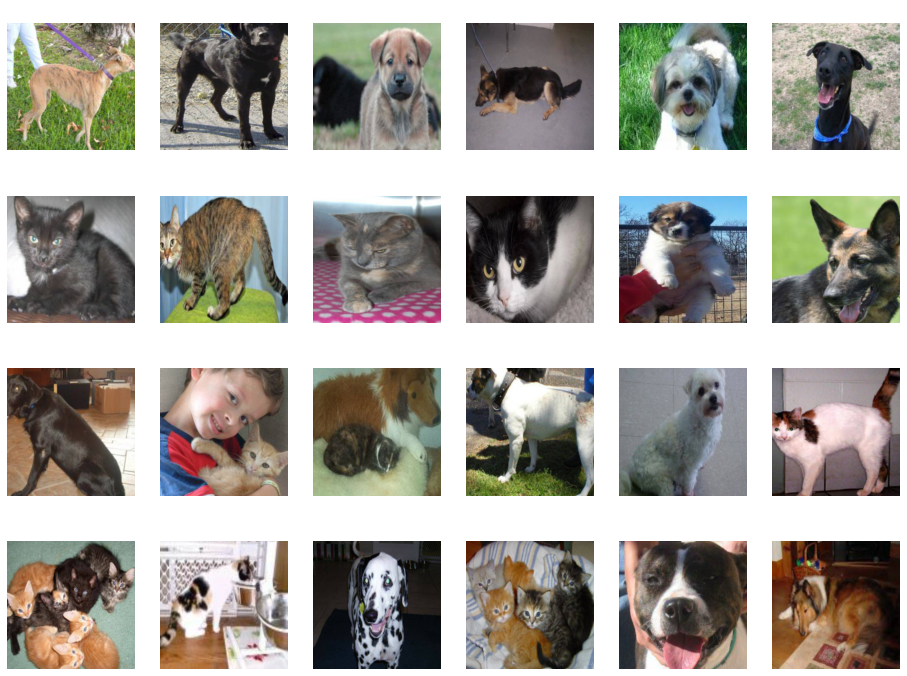

In [9]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))

for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()], color='w')
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

----------------------------------------------------------------------------------------------------------------------------------------

## Pretrained model: VGG19

![vgg19](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbw2WnC%2FbtqKSgFqB3D%2FhYW6yfkjGFXmzMMwEM7tZ1%2Fimg.png)

![vgg19_3](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2ForcNB%2FbtqKSfNennh%2F8aaQpW4iAE5AebMkdrfzrk%2Fimg.jpg)

In [11]:
model_vgg19 = torchvision.models.vgg19(pretrained=True)
model_vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
input_features_fc_layer = model_vgg19.classifier[0].in_features
input_features_fc_layer

25088

In [16]:
model_vgg19.classifier = nn.Sequential(
    nn.BatchNorm1d(input_features_fc_layer),
    nn.Linear(input_features_fc_layer, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [17]:
model_vgg19.cuda()
summary(model_vgg19, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [18]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

174.475sec : [Epoch 1/10] -> train loss: 0.1445, train acc: 95.400% / valid loss: 0.0601, valid acc: 98.480%
173.766sec : [Epoch 2/10] -> train loss: 0.0466, train acc: 98.885% / valid loss: 0.0432, valid acc: 98.640%
173.704sec : [Epoch 3/10] -> train loss: 0.0320, train acc: 99.190% / valid loss: 0.0435, valid acc: 98.200%
174.084sec : [Epoch 4/10] -> train loss: 0.0241, train acc: 99.420% / valid loss: 0.0355, valid acc: 98.760%
173.894sec : [Epoch 5/10] -> train loss: 0.0174, train acc: 99.670% / valid loss: 0.0370, valid acc: 98.680%
173.420sec : [Epoch 6/10] -> train loss: 0.0136, train acc: 99.720% / valid loss: 0.0350, valid acc: 98.760%
172.900sec : [Epoch 7/10] -> train loss: 0.0115, train acc: 99.835% / valid loss: 0.0357, valid acc: 98.880%
171.669sec : [Epoch 8/10] -> train loss: 0.0096, train acc: 99.840% / valid loss: 0.0348, valid acc: 98.720%
173.615sec : [Epoch 9/10] -> train loss: 0.0065, train acc: 99.935% / valid loss: 0.0353, valid acc: 98.720%
173.918sec : [Epoch

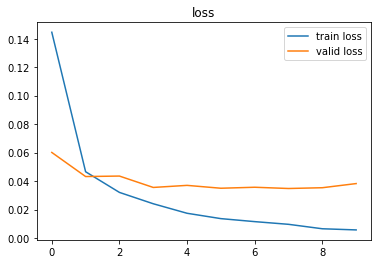

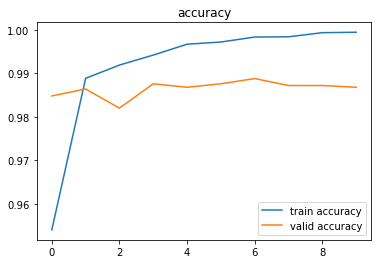

In [19]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg19.parameters(), lr=1e-5)
 
fit(model_vgg19, criterion, optimizer, 10, train_loader, valid_loader)

In [20]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [21]:
eval(model_vgg19, criterion, test_loader)

eval loss: 0.0262, eval acc: 99.040%


In [22]:
test_dir = 'data/dogs-vs-cats/test'
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=128, shuffle=False)

In [25]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret
   
pred = predict(model_vgg19, submit_loader)

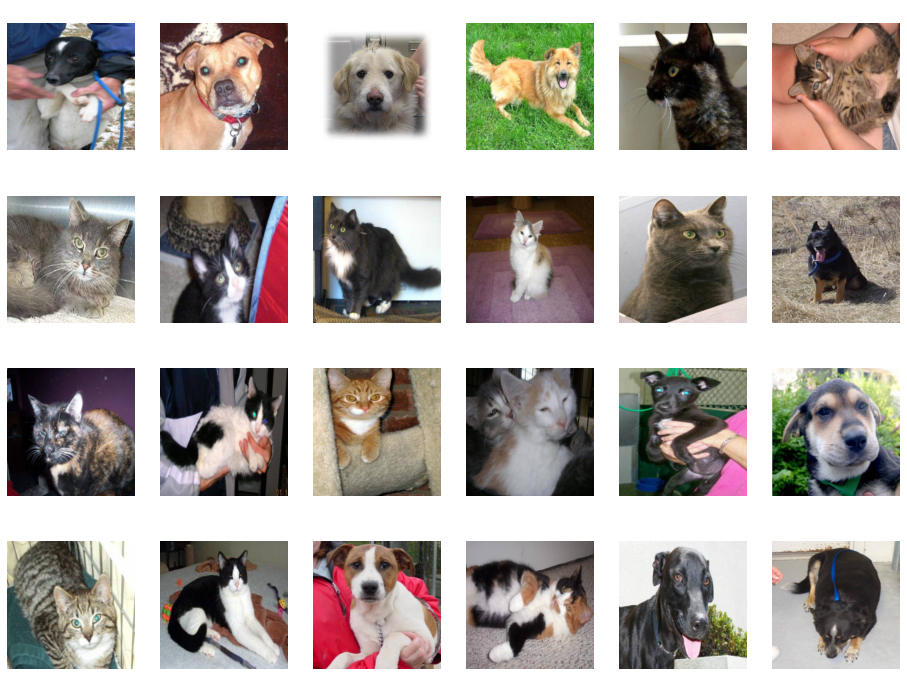

In [26]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0
 
imgs, files = iter(submit_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]], color='w')
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)